In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython import get_ipython
ipython = get_ipython()

# Autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Ignore exceptions
import expectexception

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

# Suppress rpy2 runtime warnings
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
%%R

# Visualization
library(ggplot2)
library(ggalt)
library(ggExtra)
library(ggcorrplot)
library(ggthemes)
library(ggdendro)
library(GGally)
library(ggrepel)
theme_set(theme_light())

# Tidyverse library
library(scales)
library(dplyr)
library(tidyr)
library(forcats)
library(readr)
library(purrr)

# String manipulations
library(tools)
library(lubridate)

# Machine Learning Related
library(car)
library(caTools)
library(pROC)

# Misc
library(psych)
library(mice)

In [4]:
# 1(a). Import dataset and train-test split 

cancer = pd.read_csv('../../Homework Data/Homework 6 Data/wdbc.csv', header=None)
cancer.drop(0, axis=1, inplace=True)

In [5]:
cancer.rename(columns={1: 'class'}, inplace=True)
cancer['class'].value_counts()

B    357
M    212
Name: class, dtype: int64

We have 357 benign cases and 212 malignant cases.

In [6]:
benign = cancer.loc[cancer['class']=='B']
malignant = cancer.loc[cancer['class']=='M']

In [7]:
# Extract top 20% of the data as test set

train = pd.concat([benign.iloc[71:], malignant.iloc[42:]], axis=0)
test = pd.concat([benign.iloc[:71], malignant.iloc[:42]], axis=0)

In [8]:
X_train, y_train = train.drop('class', axis=1), train['class']
X_test, y_test = test.drop('class', axis=1), test['class']

# Supervised Learning

In [9]:
# 1(b) i. Supervised Learning

# Standardize the data

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# Label encode the target

from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
y_train = lbl.fit_transform(y_train)
y_test = lbl.transform(y_test)

In [10]:
# L1-penalized SVM

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

def bayes_opt():
    # Set up space dictionary with specified hyperparameters
    space = {'alpha' : hp.loguniform('alpha', -10, 0)}

    # Set up objective function
    def objective(params):
        params = {'alpha' : params['alpha']}
        
        lin_svc = SGDClassifier(**params, penalty='l1', # Specify L1-penalty
                                max_iter=30000,
                                learning_rate='optimal', early_stopping=True) # Hinge Loss is used by default
        
        best_score = cross_val_score(lin_svc, X_train, y_train, cv=5, 
                                     scoring='accuracy', n_jobs=-1).mean() # 5-fold cv
        
        loss = 1 - best_score
        return loss

    # Run the algorithm
    best = fmin(fn=objective,
                space=space, 
                max_evals=500, # Control how many evaluations to take
                rstate=np.random.RandomState(408),
                algo=tpe.suggest)

    return best


def svc():
    best_param = bayes_opt() # Get best parameters from Bayesian Optimization
    lin_svc = SGDClassifier(**best_param, penalty='l1', 
                            max_iter=30000,
                            learning_rate='optimal', early_stopping=True)
    lin_svc.fit(X_train, y_train)
    return best_param, lin_svc.predict(X_train), lin_svc.predict(X_test),\
           lin_svc.decision_function(X_train), lin_svc.decision_function(X_test)

In [11]:
best_param, y_pred_train, y_pred_test, y_pred_train_dist, y_pred_test_dist = svc()
best_param

100%|██████████| 500/500 [00:14<00:00, 34.44it/s, best loss: 0.01975633062589588] 


{'alpha': 0.0007988416667574656}

In [12]:
# Metrics for training set

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

train_report = classification_report(y_train, y_pred_train, output_dict=True)
train_weighted_avg = train_report['weighted avg']
auc_train = roc_auc_score(y_train, y_pred_train_dist)

print('The train accuracy is {:.3}.'.format(train_report['accuracy']))
print('The average train precision, recall, f1-score and AUC are {:.3}, {:.3}, {:.3} and {:.3} respectively.'.format(
       train_weighted_avg['precision'], train_weighted_avg['recall'], train_weighted_avg['f1-score'], auc_train))

The train accuracy is 0.976.
The average train precision, recall, f1-score and AUC are 0.976, 0.976, 0.976 and 0.995 respectively.


In [13]:
# ROC curve for training set

fpr, tpr, _ = roc_curve(y_train, y_pred_train_dist)

roc_curve_train_supervised = pd.DataFrame(np.column_stack([tpr, fpr]),
                                          columns=['tpr', 'fpr'])

In [14]:
%%R -i roc_curve_train_supervised

gg = ggplot(roc_curve_train_supervised, aes(fpr, tpr)) +
        geom_line() +
        geom_abline(slope=1, intercept=0, linetype='dashed', col='tomato2') +
        labs(title='ROC Curve on Train Data (Superivsed)',
             x='False Positive Rate',
             y='True Positive Rate')

png(file='./HW6_image/roc_train_supervised.png', width=500, height=500)
gg

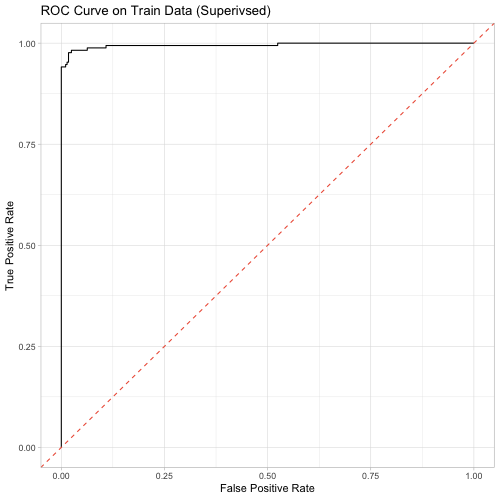

In [15]:
Image('./HW6_image/roc_train_supervised.png')

In [16]:
# Metrics for testing set

test_report = classification_report(y_test, y_pred_test, output_dict=True)
test_weighted_avg = test_report['weighted avg']
auc_test = roc_auc_score(y_test, y_pred_test_dist)

print('The test accuracy is {:.3}.'.format(test_report['accuracy']))
print('The average test precision, recall, f1-score and AUC are {:.3}, {:.3}, {:.3} and {:.3} respectively.'.format(
       test_weighted_avg['precision'], test_weighted_avg['recall'], test_weighted_avg['f1-score'], auc_test))

The test accuracy is 0.973.
The average test precision, recall, f1-score and AUC are 0.973, 0.973, 0.973 and 0.993 respectively.


In [17]:
# ROC curve for testing set

fpr, tpr, _ = roc_curve(y_test, y_pred_test_dist)

roc_curve_test_supervised = pd.DataFrame(np.column_stack([tpr, fpr]),
                                          columns=['tpr', 'fpr'])

In [18]:
%%R -i roc_curve_test_supervised

gg = ggplot(roc_curve_test_supervised, aes(fpr, tpr)) +
        geom_line() +
        geom_abline(slope=1, intercept=0, linetype='dashed', col='tomato2') +
        labs(title='ROC Curve on Test Data (Superivsed)',
             x='False Positive Rate',
             y='True Positive Rate')

png(file='./HW6_image/roc_test_supervised.png', width=500, height=500)
gg

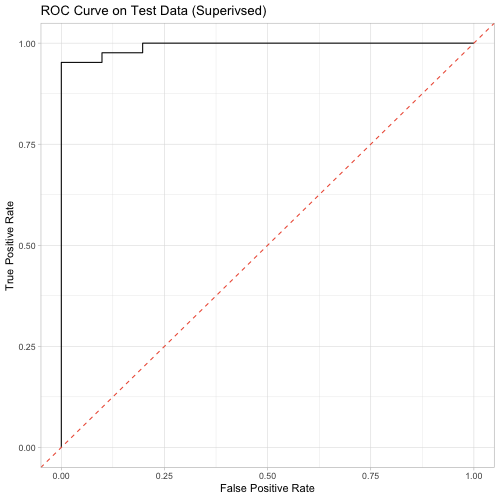

In [19]:
Image('./HW6_image/roc_test_supervised.png')

In [20]:
# Monte-Carlo Simulation for Supervised Learning

X = cancer.iloc[:, 1:]
y = cancer.iloc[:, 0]

In [21]:
from sklearn.model_selection import train_test_split

train_accuracy = []
train_precision = []
train_recall = []
train_f_score = []
train_auc = []

test_accuracy = []
test_precision = []
test_recall = []
test_f_score = []
test_auc = []

# Run for 30 rounds
for num in range(1, 31):
    # Split the data set randomly, in a stratified manner
    rand_int = np.random.randint(1e9)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=rand_int)
    
    # Transform the data accordingly
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
    
    lbl = LabelEncoder()
    y_train = lbl.fit_transform(y_train)
    y_test = lbl.transform(y_test)

    # Get optimized hyperparameters for each round
    def bayes_opt():
        # Set up space dictionary with specified hyperparameters
        space = {'alpha' : hp.loguniform('alpha', -10, 0)}

        # Set up objective function
        def objective(params):
            params = {'alpha' : params['alpha']}
            lin_svc = SGDClassifier(**params, penalty='l1', # Specify L1-penalty
                                    max_iter=30000,
                                    learning_rate='optimal', early_stopping=True) # Hinge Loss is used by default
            best_score = cross_val_score(lin_svc, X_train, y_train, cv=5, 
                                         scoring='accuracy', n_jobs=-1).mean() # 5-fold cv
            loss = 1 - best_score
            return loss

        # Run the algorithm
        best = fmin(fn=objective,
                    space=space, 
                    max_evals=500, # Control how many evaluations to take
                    rstate=np.random.RandomState(408),
                    algo=tpe.suggest,
                    show_progressbar=False) # Suppress progress bar
        return best


    def svc():
        best_param = bayes_opt() # Get best parameters from Bayesian Optimization
        lin_svc = SGDClassifier(**best_param, penalty='l1', 
                                max_iter=30000,
                                learning_rate='optimal', early_stopping=True)
        lin_svc.fit(X_train, y_train)
        return best_param, lin_svc.predict(X_train), lin_svc.predict(X_test),\
               lin_svc.decision_function(X_train), lin_svc.decision_function(X_test)
    
    # Extract predictions and distance to decision hyperplane for both train and test sets
    best_param, y_pred_train, y_pred_test, y_pred_train_dist, y_pred_test_dist = svc()
    
    # Append the results accordingly
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    train_weighted_avg = train_report['weighted avg']
    auc_train = roc_auc_score(y_train, y_pred_train_dist)
    train_accuracy.append(train_report['accuracy'])
    train_precision.append(train_weighted_avg['precision'])
    train_recall.append(train_weighted_avg['recall'])
    train_f_score.append(train_weighted_avg['f1-score'])
    train_auc.append(auc_train)
    
    test_report = classification_report(y_test, y_pred_test, output_dict=True)
    test_weighted_avg = test_report['weighted avg']
    auc_test = roc_auc_score(y_test, y_pred_test_dist)
    test_accuracy.append(test_report['accuracy'])
    test_precision.append(test_weighted_avg['precision'])
    test_recall.append(test_weighted_avg['recall'])
    test_f_score.append(test_weighted_avg['f1-score'])
    test_auc.append(auc_test)
    
    # Keep track of iterations
    if num%5 == 0:
        print('{} iterations done!'.format(num))

5 iterations done!
10 iterations done!
15 iterations done!
20 iterations done!
25 iterations done!
30 iterations done!


In [22]:
print('The averaged train accuracy, precision, recall, f1-score and AUC are {:.3}, {:.3}, {:.3}, {:.3} and {:.3} respectively. \n'.format(
       np.mean(train_accuracy), np.mean(train_precision), np.mean(train_recall), 
       np.mean(train_f_score), np.mean(train_auc)))

print('The averaged test accuracy, precision, recall, f1-score and AUC are {:.3}, {:.3}, {:.3}, {:.3} and {:.3} respectively.'.format(
       np.mean(test_accuracy), np.mean(test_precision), np.mean(test_recall), 
       np.mean(test_f_score), np.mean(test_auc)))

The averaged train accuracy, precision, recall, f1-score and AUC are 0.97, 0.971, 0.97, 0.97 and 0.996 respectively. 

The averaged test accuracy, precision, recall, f1-score and AUC are 0.962, 0.964, 0.962, 0.962 and 0.994 respectively.


# Semi-supervised Learning

In [23]:
train_benign = train.loc[train['class']=='B']
train_malignant = train.loc[train['class']=='M']

In [24]:
# Split the data accordingly

benign_labelled = train_benign.sample(frac=0.5, random_state=408)
malignant_labelled = train_malignant.sample(frac=0.5, random_state=408)

benign_unlabelled = train_benign.loc[~train_benign.index.isin(benign_labelled.index), :].drop('class', axis=1)
malignant_unlabelled = train_malignant.loc[
    ~train_malignant.index.isin(malignant_labelled.index), :].drop('class', axis=1)

In [25]:
labelled = pd.concat([benign_labelled, malignant_labelled], axis=0)
unlabelled = pd.concat([benign_unlabelled, malignant_unlabelled], axis=0)

In [26]:
# Preprocess data accordingly

X_train, y_train = labelled.drop('class', axis=1), labelled['class']
X_test, y_test = test.drop('class', axis=1), test['class']

X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)
unlabelled = mms.transform(unlabelled)

y_train = lbl.fit_transform(y_train)
y_test = lbl.transform(y_test)

In [27]:
def bayes_opt():
    # Set up space dictionary with specified hyperparameters
    space = {'alpha' : hp.loguniform('alpha', -12, 0)}

    # Set up objective function
    def objective(params):
        params = {'alpha' : params['alpha']}
        
        lin_svc = SGDClassifier(**params, penalty='l1', # Specify L1-penalty
                                max_iter=30000,
                                learning_rate='optimal', early_stopping=True) # Hinge Loss is used by default
        
        best_score = cross_val_score(lin_svc, X_train, y_train, cv=5, 
                                     scoring='accuracy', n_jobs=-1).mean() # 5-fold cv
        
        loss = 1 - best_score
        return loss

    # Run the algorithm
    best = fmin(fn=objective,
                space=space, 
                max_evals=500, # Control how many evaluations to take
                rstate=np.random.RandomState(408),
                algo=tpe.suggest)

    return best


def svc2(X_train, y_train, unlabelled):
    
    best_param = bayes_opt() # Get best parameters from Bayesian Optimization
    lin_svc = SGDClassifier(**best_param, penalty='l1', 
                            max_iter=30000,
                            learning_rate='optimal', early_stopping=True)
    
    unlabelled_size = unlabelled.shape[0]
    
    while unlabelled_size > 0: # continue self-training until all the unlabelled data are used
        # Re-train the SVM iteratively
        lin_svc.fit(X_train, y_train)
        
        # Get distance to hyperplanes for unlabelled data
        hyperplane_dist = lin_svc.decision_function(unlabelled)
       
        # Get index corresponds to the point that is farthest to the hyperplane
        desired_index = np.where(np.abs(hyperplane_dist) == np.max(np.abs(hyperplane_dist)))
        
        # Assign new y to 1 if the distance to the hyperplane is positive, vice versa
        new_X = unlabelled[desired_index]
        new_y = np.where(hyperplane_dist[desired_index] >= 0, 1, 0)
       
        # Append the self-training point to train data
        X_train = np.append(X_train, new_X, axis=0)
        y_train = np.append(y_train, new_y)
        
        # Delete the corresponding array from unlabelled data
        unlabelled = np.delete(unlabelled, desired_index, axis=0)

        unlabelled_size -= 1
            
    return best_param, lin_svc.predict(X_train), lin_svc.predict(X_test),\
           lin_svc.decision_function(X_train), lin_svc.decision_function(X_test), y_train

In [28]:
best_param, y_pred_train, y_pred_test, y_pred_train_dist,\
y_pred_test_dist, new_y_train = svc2(X_train, y_train, unlabelled)

best_param

100%|██████████| 500/500 [00:09<00:00, 51.78it/s, best loss: 0.02608695652173909]


{'alpha': 0.0011511417972171832}

In [29]:
# Metrics for training set

train_report = classification_report(new_y_train, y_pred_train, output_dict=True)
train_weighted_avg = train_report['weighted avg']
auc_train = roc_auc_score(new_y_train, y_pred_train_dist)

print('The train accuracy is {:.3}.'.format(train_report['accuracy']))
print('The average train precision, recall, f1-score and AUC are {:.3}, {:.3}, {:.3} and {:.3} respectively.'.format(
       train_weighted_avg['precision'], train_weighted_avg['recall'], train_weighted_avg['f1-score'], auc_train))

The train accuracy is 0.98.
The average train precision, recall, f1-score and AUC are 0.98, 0.98, 0.98 and 0.999 respectively.


In [30]:
# ROC curve for training set

fpr, tpr, _ = roc_curve(new_y_train, y_pred_train_dist)

roc_curve_train_semi_supervised = pd.DataFrame(np.column_stack([tpr, fpr]),
                                          columns=['tpr', 'fpr'])

In [31]:
%%R -i roc_curve_train_semi_supervised

gg = ggplot(roc_curve_train_semi_supervised, aes(fpr, tpr)) +
        geom_line() +
        geom_abline(slope=1, intercept=0, linetype='dashed', col='tomato2') +
        labs(title='ROC Curve on Train Data (Semi-superivsed)',
             x='False Positive Rate',
             y='True Positive Rate')

png(file='./HW6_image/roc_train_semi_supervised.png', width=500, height=500)
gg

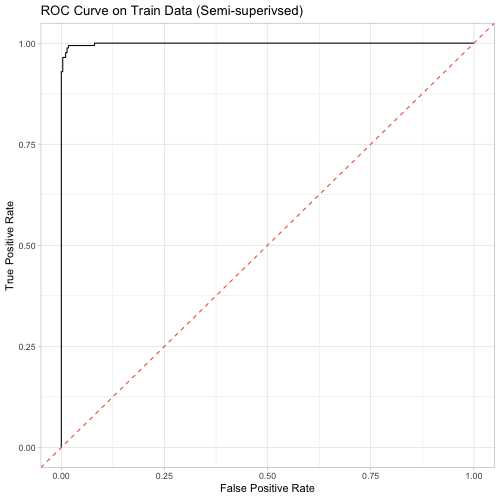

In [32]:
Image('./HW6_image/roc_train_semi_supervised.png')

In [33]:
# Metrics for testing set

test_report = classification_report(y_test, y_pred_test, output_dict=True)
test_weighted_avg = test_report['weighted avg']
auc_test = roc_auc_score(y_test, y_pred_test_dist)

print('The test accuracy is {:.3}.'.format(test_report['accuracy']))
print('The average test precision, recall, f1-score and AUC are {:.3}, {:.3}, {:.3} and {:.3} respectively.'.format(
       test_weighted_avg['precision'], test_weighted_avg['recall'], test_weighted_avg['f1-score'], auc_test))

The test accuracy is 0.956.
The average test precision, recall, f1-score and AUC are 0.956, 0.956, 0.956 and 0.989 respectively.


In [34]:
# ROC curve for testing set

fpr, tpr, _ = roc_curve(y_test, y_pred_test_dist)

roc_curve_test_semi_supervised = pd.DataFrame(np.column_stack([tpr, fpr]),
                                          columns=['tpr', 'fpr'])

In [35]:
%%R -i roc_curve_test_semi_supervised

gg = ggplot(roc_curve_test_semi_supervised, aes(fpr, tpr)) +
        geom_line() +
        geom_abline(slope=1, intercept=0, linetype='dashed', col='tomato2') +
        labs(title='ROC Curve on Test Data (Semi-superivsed)',
             x='False Positive Rate',
             y='True Positive Rate')

png(file='./HW6_image/roc_test_semi_supervised.png', width=500, height=500)
gg

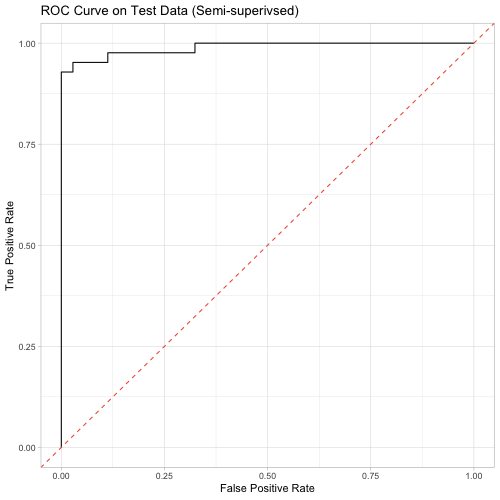

In [36]:
Image('./HW6_image/roc_test_semi_supervised.png')

In [37]:
# Monte-Carlo simulation for semi-supervised learning

train_accuracy = []
train_precision = []
train_recall = []
train_f_score = []
train_auc = []

test_accuracy = []
test_precision = []
test_recall = []
test_f_score = []
test_auc = []

for num in range(1, 31):
    # Split the data set randomly, in a stratified manner
    rand_int = np.random.randint(1e9)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                        stratify=y, random_state=rand_int)
    
    # Randomly mask half of the training set
    X_train, unlabelled, y_train, _ = train_test_split(X_train, y_train, test_size=0.50, 
                                                       stratify=y_train, random_state=rand_int)
    
    # Transform the data accordingly
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
    unlabelled = mms.transform(unlabelled)

    lbl = LabelEncoder()
    y_train = lbl.fit_transform(y_train)
    y_test = lbl.transform(y_test)

    # Get optimized hyperparameters for each round
    def bayes_opt():
        # Set up space dictionary with specified hyperparameters
        space = {'alpha' : hp.loguniform('alpha', -12, 0)}

        # Set up objective function
        def objective(params):
            params = {'alpha' : params['alpha']}

            lin_svc = SGDClassifier(**params, penalty='l1', # Specify L1-penalty
                                    max_iter=30000,
                                    learning_rate='optimal', early_stopping=True) # Hinge Loss is used by default

            best_score = cross_val_score(lin_svc, X_train, y_train, cv=5, 
                                         scoring='accuracy', n_jobs=-1).mean() # 5-fold cv

            loss = 1 - best_score
            return loss

        # Run the algorithm
        best = fmin(fn=objective,
                    space=space, 
                    max_evals=500, # Control how many evaluations to take
                    rstate=np.random.RandomState(408),
                    algo=tpe.suggest,
                    show_progressbar=False) # Suppress progress bar

        return best

    
    def svc2(X_train, y_train, unlabelled):

        best_param = bayes_opt() # Get best parameters from Bayesian Optimization
        lin_svc = SGDClassifier(**best_param, penalty='l1', 
                                max_iter=30000,
                                learning_rate='optimal', early_stopping=True)

        unlabelled_size = unlabelled.shape[0]

        while unlabelled_size > 0: # continue self-training until all the unlabelled data are used
            # Re-train the SVM iteratively
            lin_svc.fit(X_train, y_train)

            # Get distance to hyperplanes for unlabelled data
            hyperplane_dist = lin_svc.decision_function(unlabelled)

            # Get index corresponds to the point that is farthest to the hyperplane
            desired_index = np.where(np.abs(hyperplane_dist) == np.max(np.abs(hyperplane_dist)))

            # Assign new y to 1 if the distance to the hyperplane is positive, vice versa
            new_X = unlabelled[desired_index]
            new_y = np.where(hyperplane_dist[desired_index] >= 0, 1, 0)

            # Append the self-training point to train data
            X_train = np.append(X_train, new_X, axis=0)
            y_train = np.append(y_train, new_y)

            # Delete the corresponding array from unlabelled data
            unlabelled = np.delete(unlabelled, desired_index, axis=0)

            unlabelled_size -= 1

        return best_param, lin_svc.predict(X_train), lin_svc.predict(X_test),\
               lin_svc.decision_function(X_train), lin_svc.decision_function(X_test), y_train

    
    # Extract predictions and distance to decision hyperplane for both train and test sets
    best_param, y_pred_train, y_pred_test, y_pred_train_dist,\
    y_pred_test_dist, new_y_train = svc2(X_train, y_train, unlabelled)
    
    # Append the results accordingly
    train_report = classification_report(new_y_train, y_pred_train, output_dict=True)
    train_weighted_avg = train_report['weighted avg']
    auc_train = roc_auc_score(new_y_train, y_pred_train_dist)
    train_accuracy.append(train_report['accuracy'])
    train_precision.append(train_weighted_avg['precision'])
    train_recall.append(train_weighted_avg['recall'])
    train_f_score.append(train_weighted_avg['f1-score'])
    train_auc.append(auc_train)
    
    test_report = classification_report(y_test, y_pred_test, output_dict=True)
    test_weighted_avg = test_report['weighted avg']
    auc_test = roc_auc_score(y_test, y_pred_test_dist)
    test_accuracy.append(test_report['accuracy'])
    test_precision.append(test_weighted_avg['precision'])
    test_recall.append(test_weighted_avg['recall'])
    test_f_score.append(test_weighted_avg['f1-score'])
    test_auc.append(auc_test)
    
    # Keep track of iterations
    if num%5 == 0:
        print('{} iterations done!'.format(num))

5 iterations done!
10 iterations done!
15 iterations done!
20 iterations done!
25 iterations done!
30 iterations done!


In [38]:
print('The averaged train accuracy, precision, recall, f1-score and AUC are {:.3}, {:.3}, {:.3}, {:.3} and {:.3} respectively. \n'.format(
       np.mean(train_accuracy), np.mean(train_precision), np.mean(train_recall), 
       np.mean(train_f_score), np.mean(train_auc)))

print('The averaged test accuracy, precision, recall, f1-score and AUC are {:.3}, {:.3}, {:.3}, {:.3} and {:.3} respectively.'.format(
       np.mean(test_accuracy), np.mean(test_precision), np.mean(test_recall), 
       np.mean(test_f_score), np.mean(test_auc)))

The averaged train accuracy, precision, recall, f1-score and AUC are 0.977, 0.978, 0.977, 0.977 and 0.998 respectively. 

The averaged test accuracy, precision, recall, f1-score and AUC are 0.963, 0.965, 0.963, 0.963 and 0.995 respectively.


# Unsupervised Learning

In [112]:
# Split the data accordingly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    stratify=y, random_state=408)

# Preprocess the data accordingly

X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

y_train = lbl.fit_transform(y_train)
y_test = lbl.transform(y_test)

In [113]:
# K-means clustering

from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=2, 
                         batch_size=50,
                         n_init=200,
                         random_state=408)
cluster_label_train = kmeans.fit_predict(X_train)
cluster_label_test = kmeans.predict(X_test)
dist_to_center = kmeans.transform(X_train)

We can avoid achieving bad local minimum by setting n_init to a higher number, the initialization with the lowest inertia would be used.

In [114]:
# Extract corresponding indices of the cloest 30 datapoints to each cluster

s = list(enumerate(dist_to_center))

close_to_0 = sorted(s, key = lambda x: x[1][0])[:30]
close_to_1 = sorted(s, key = lambda x: x[1][1])[:30]

indices_0 = [x[0] for x in close_to_0]
indices_1 = [x[0] for x in close_to_1]

In [115]:
# Slice the true labels and label accordingly

from statistics import mode

mode_0 = mode(y_train[indices_0])
mode_1 = mode(y_train[indices_1])

cluster_label_train = np.where(cluster_label_train==0, mode_0, mode_1)
cluster_label_test = np.where(cluster_label_test==0, mode_0, mode_1)

In [116]:
# Metrics for training set

train_report = classification_report(y_train, cluster_label_train, output_dict=True)
train_weighted_avg = train_report['weighted avg']

print('The train accuracy is {:.3}.'.format(train_report['accuracy']))
print('The average train precision, recall and f1-score are {:.3}, {:.3} and {:.3} respectively.'.format(
       train_weighted_avg['precision'], train_weighted_avg['recall'], train_weighted_avg['f1-score']))

The train accuracy is 0.919.
The average train precision, recall and f1-score are 0.92, 0.919 and 0.918 respectively.


In [117]:
# Metrics for testing set

test_report = classification_report(y_test, cluster_label_test, output_dict=True)
test_weighted_avg = test_report['weighted avg']

print('The test accuracy is {:.3}.'.format(test_report['accuracy']))
print('The average test precision, recall and f1-score are {:.3}, {:.3} and {:.3} respectively.'.format(
       test_weighted_avg['precision'], test_weighted_avg['recall'], test_weighted_avg['f1-score']))

The test accuracy is 0.921.
The average test precision, recall and f1-score are 0.921, 0.921 and 0.921 respectively.


In [118]:
# Monte-Carlo simulation for unsupervised learning

train_accuracy = []
train_precision = []
train_recall = []
train_f_score = []

test_accuracy = []
test_precision = []
test_recall = []
test_f_score = []

for _ in range(30):
    
    rand_int = np.random.randint(1e9)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                        stratify=y, random_state=rand_int)
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
    y_train = lbl.fit_transform(y_train)
    y_test = lbl.transform(y_test)
    
    kmeans = MiniBatchKMeans(n_clusters=2, 
                             batch_size=50,
                             n_init=200,
                             random_state=rand_int)
    cluster_label_train = kmeans.fit_predict(X_train)
    cluster_label_test = kmeans.predict(X_test)
    dist_to_center = kmeans.transform(X_train)
    
    s = list(enumerate(dist_to_center))
    close_to_0 = sorted(s, key = lambda x: x[1][0])[:30]
    close_to_1 = sorted(s, key = lambda x: x[1][1])[:30]
    indices_0 = [x[0] for x in close_to_0]
    indices_1 = [x[0] for x in close_to_1]
    mode_0 = mode(y_train[indices_0])
    mode_1 = mode(y_train[indices_1])
    
    cluster_label_train = np.where(cluster_label_train==0, mode_0, mode_1)
    cluster_label_test = np.where(cluster_label_test==0, mode_0, mode_1)
    
    train_report = classification_report(y_train, cluster_label_train, output_dict=True)
    train_weighted_avg = train_report['weighted avg']
    train_accuracy.append(train_report['accuracy'])
    train_precision.append(train_weighted_avg['precision'])
    train_recall.append(train_weighted_avg['recall'])
    train_f_score.append(train_weighted_avg['f1-score'])
    
    test_report = classification_report(y_test, cluster_label_test, output_dict=True)
    test_weighted_avg = test_report['weighted avg']
    test_accuracy.append(test_report['accuracy'])
    test_precision.append(test_weighted_avg['precision'])
    test_recall.append(test_weighted_avg['recall'])
    test_f_score.append(test_weighted_avg['f1-score'])

In [119]:
print('The averaged train accuracy, precision, recall and f1-score are {:.3}, {:.3}, {:.3} and {:.3} respectively. \n'.format(
       np.mean(train_accuracy), np.mean(train_precision), np.mean(train_recall), np.mean(train_f_score)))

print('The averaged test accuracy, precision, recall and f1-score are {:.3}, {:.3}, {:.3} and {:.3} respectively.'.format(
       np.mean(test_accuracy), np.mean(test_precision), np.mean(test_recall), np.mean(test_f_score)))

The averaged train accuracy, precision, recall and f1-score are 0.93, 0.932, 0.93 and 0.929 respectively. 

The averaged test accuracy, precision, recall and f1-score are 0.915, 0.918, 0.915 and 0.913 respectively.


# Spectral Clustering

In [151]:
# Split the data accordingly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    stratify=y, random_state=408)

# Preprocess the data accordingly

X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

y_train = lbl.fit_transform(y_train)
y_test = lbl.transform(y_test)

In [152]:
from sklearn.cluster import SpectralClustering

spec_clust = SpectralClustering(n_clusters=2,
                                n_init=100,
                                random_state=408,
                                n_jobs=-1)

cluster_label_train = spec_clust.fit_predict(X_train)
cluster_label_test = spec_clust.fit_predict(X_test)

In [153]:
indices_0 = np.where(cluster_label_train==0)
indices_1 = np.where(cluster_label_train==1)

In [154]:
mode_0 = mode(y_train[indices_0])
mode_1 = mode(y_train[indices_1])

cluster_label_train = np.where(cluster_label_train==0, mode_0, mode_1)
cluster_label_test = np.where(cluster_label_test==0, mode_0, mode_1)

In [155]:
# Metrics for training set

train_report = classification_report(y_train, cluster_label_train, output_dict=True)
train_weighted_avg = train_report['weighted avg']

print('The train accuracy is {:.3}.'.format(train_report['accuracy']))
print('The average train precision, recall and f1-score are {:.3}, {:.3} and {:.3} respectively.'.format(
       train_weighted_avg['precision'], train_weighted_avg['recall'], train_weighted_avg['f1-score']))

The train accuracy is 0.877.
The average train precision, recall and f1-score are 0.893, 0.877 and 0.871 respectively.


In [156]:
# Metrics for testing set

test_report = classification_report(y_test, cluster_label_test, output_dict=True)
test_weighted_avg = test_report['weighted avg']

print('The test accuracy is {:.3}.'.format(test_report['accuracy']))
print('The average test precision, recall and f1-score are {:.3}, {:.3} and {:.3} respectively.'.format(
       test_weighted_avg['precision'], test_weighted_avg['recall'], test_weighted_avg['f1-score']))

The test accuracy is 0.719.
The average test precision, recall and f1-score are 0.806, 0.719 and 0.658 respectively.


In [157]:
# Monte-Carlo simulation for Spectral Clustering

train_accuracy = []
train_precision = []
train_recall = []
train_f_score = []

test_accuracy = []
test_precision = []
test_recall = []
test_f_score = []

for _ in range(30):
    
    rand_int = np.random.randint(1e9)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                        stratify=y, random_state=rand_int)
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
    y_train = lbl.fit_transform(y_train)
    y_test = lbl.transform(y_test)
    
    spec_clust = SpectralClustering(n_clusters=2,
                                n_init=100,
                                random_state=rand_int,
                                n_jobs=-1)
    cluster_label_train = spec_clust.fit_predict(X_train)
    cluster_label_test = spec_clust.fit_predict(X_test)
    
    indices_0 = np.where(cluster_label_train==0)
    indices_1 = np.where(cluster_label_train==1)
    mode_0 = mode(y_train[indices_0])
    mode_1 = mode(y_train[indices_1])
    cluster_label_train = np.where(cluster_label_train==0, mode_0, mode_1)
    cluster_label_test = np.where(cluster_label_test==0, mode_0, mode_1)
    
    train_report = classification_report(y_train, cluster_label_train, output_dict=True)
    train_weighted_avg = train_report['weighted avg']
    train_accuracy.append(train_report['accuracy'])
    train_precision.append(train_weighted_avg['precision'])
    train_recall.append(train_weighted_avg['recall'])
    train_f_score.append(train_weighted_avg['f1-score'])
    
    test_report = classification_report(y_test, cluster_label_test, output_dict=True)
    test_weighted_avg = test_report['weighted avg']
    test_accuracy.append(test_report['accuracy'])
    test_precision.append(test_weighted_avg['precision'])
    test_recall.append(test_weighted_avg['recall'])
    test_f_score.append(test_weighted_avg['f1-score'])

In [158]:
print('The averaged train accuracy, precision, recall and f1-score are {:.3}, {:.3}, {:.3} and {:.3} respectively. \n'.format(
       np.mean(train_accuracy), np.mean(train_precision), np.mean(train_recall), np.mean(train_f_score)))

print('The averaged test accuracy, precision, recall and f1-score are {:.3}, {:.3}, {:.3} and {:.3} respectively.'.format(
       np.mean(test_accuracy), np.mean(test_precision), np.mean(test_recall), np.mean(test_f_score)))

The averaged train accuracy, precision, recall and f1-score are 0.854, 0.878, 0.854 and 0.844 respectively. 

The averaged test accuracy, precision, recall and f1-score are 0.532, 0.531, 0.532 and 0.495 respectively.


# Comparison Between 4 Classifiers

- It is observed that the *supervised learning on the full data set* **performs similarly** to the *semi-supervised learning with half of the data set labeled*. **Theoretically, the former is supposed to work better than the later one.** However, this could happen by chance because the number of Monte-Carlo Simulations for each classifiers is only performed a relatively small time.

- The unsupervised learnings under-performs compared to their supervised learning counterparts, which is expected.